# Numpy to Build Neural Network

In [85]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE
from sklearn.metrics import mean_squared_error
import numpy as np

# Utility functions

In [86]:
def plot_3d(comp, graph_title, X, y, y_pred=None):
    X_tnse = TSNE(n_components=comp, random_state=123).fit_transform(X)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X_tnse[:,0], X_tnse[:,1], y, label='y_true')
    ax.set_title(graph_title)
    if y_pred is not None:
        ax.scatter(X_tnse[:,0], X_tnse[:,1], y_pred, label='y_pred', marker='v')
    plt.legend()
    plt.show()

# Generating Sample data 3 inputs & 2 output

In [87]:
n = 200

# We need to take 3 inputs
inputs_dimensions = 3

# We need to have 2 outputs
output_dimensions = 2

# Setup some random seed
np.random.seed(2232)

# Generating X with 3 dimentions
X = np.random.uniform(-1, 1, (n, inputs_dimensions))
print('Sample Value for X:' + str(X[:3]))

# Generating the value of the y_true
weights_true = np.array([[4,3,-2],[-1,-1,3]])
bias_true = np.array([[1],[1]])

y_true = (9 * X ** 2) @ weights_true.T + X @ weights_true.T + bias_true.T

print('Sample Value for y:'+ str(y_true[:3]))


Sample Value for X:[[-0.34381746 -0.21874254  0.4211479 ]
 [ 0.63720264 -0.36557595 -0.84401555]
 [ 0.12846155 -0.76045417  0.91954116]]
Sample Value for y:[[ 0.48110695  6.12034493]
 [ 9.54300863 12.57305053]
 [-1.6186757  21.86749061]]


# Plotting the data in a 3-Dimentional Plane

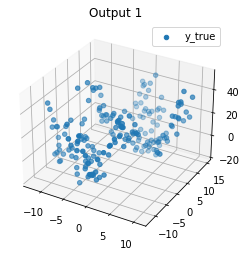

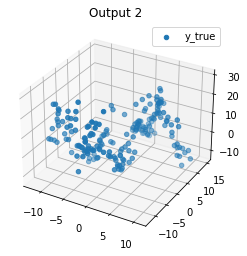

In [88]:
plot_3d(2, 'Output 1', X, y_true[:,0])
plot_3d(2, 'Output 2', X, y_true[:,1])

# Hyperparameters - Various Parameters that we will be using

In [89]:
# Number of Iterations
epochs = 200

# Learning rate of the algorithm
learning_rate = 0.01

# Inputs and outputs size. i.e 2 and 3 relatively
inputs = X.shape[1]
outputs = y_true.shape[1]

print(inputs)
print(outputs)

3
2


In [90]:
class Layer:
    def __init__(self, num_input_nodes=1, num_output_nodes=1, activation=None):
        self.num_input_nodes = num_input_nodes
        self.num_output_nodes = num_output_nodes
        # Init layer with random weights and bias
        self.weights = np.random.rand(num_input_nodes, num_output_nodes)
        self.bias = np.random.rand((1))
        self.X = np.zeros([num_input_nodes])
        # Set activation function
        if activation == 'relu':
            self.activation = Relu()
        else: 
            self.activation = None
  
    def forward(self, X):
        self.X = X.copy()
        self.Z = X @ self.weights + self.bias
        # Pass output to activation function
        if self.activation == None:
            return self.Z 
        else:
            return self.activation.forward(self.Z)

    # Refered for math resource: https://www.kdnuggets.com/2019/08/numpy-neural-networks-computational-graphs.html
    def backward(self, upstream_gradient):
        curr_upstream_gradient = upstream_gradient.copy()
        # Perform backpropagation on activation function first before backpropagation on weight and bias gradient
        if self.activation != None:
            curr_upstream_gradient = self.activation.backward(curr_upstream_gradient)

        # Compute the gradient of the weights wrt to loss by taking dot product of upstream gradient with local gradient
        self.dJdW = self.X.T @ curr_upstream_gradient
        # Bias is a constant so its derivative is 1 and the dot product of 1 and the upstream gradient is the sum of the gradient
        self.dJdb = curr_upstream_gradient.sum()
        # Compute the gradient of input X wrt to loss by taking dot product of upstream gradient with local gradient. 
        # This value is returned because it serves as the new "upstream" gradient in the previous layer
        self.dJdX = curr_upstream_gradient @ self.weights.T
        return self.dJdX

    # Update weight and bias params with learning rate step size
    def update(self, lr):
        self.weights = self.weights - lr * self.dJdW
        self.bias = self.bias - lr * self.dJdb

    def __str__(self):
        return 'Layer: ({},{}) Activation Function: {}\nInputs:\n{}\nWeights:\n{}\nBias:{}'.format(self.num_input_nodes, self.num_output_nodes, self.activation, self.X[:2], self.weights, self.bias)

class Relu:
    def __init__(self):
        self.input = np.array([])

    def forward(self, input):
        self.input = input.copy()
        self.output = np.clip(self.input, 0, None)
        return self.output
  
    # If input is less than 0, derivative is 0. If input is greater than 0, derivative is 1
    def backward(self, upstream_gradient):
        return (self.input > 0) * upstream_gradient
  
    # No update needed to ReLU members
    def update(self, lr):
        return

    def __str__(self):
        return 'ReLu'

class Model:
    def __init__(self, num_inputs=3, num_hidden=[2], num_outputs=2, activation=None):
        self.num_inputs = num_inputs
        self.num_hidden = num_hidden
        self.num_outputs = num_outputs

        layers = [self.num_inputs] + self.num_hidden + [self.num_outputs]

        self.layers = []
        for i in range(len(layers[:-1])):
          # Don't add activation function to last layer because this is a regression problem
            if i == len(layers[:-1]) - 1:
                self.layers.append(Layer(layers[i], layers[i + 1], activation=None))
            else:
                self.layers.append(Layer(layers[i], layers[i + 1], activation))

        # Print network architecture for debugging
        print('Neural Net Architecture:')
        for i, layer in enumerate(self.layers):
            print('=== Layer {} ==='.format(i))
            print(layer)
        print()

    def forward(self, inputs):
        curr_out = inputs.copy()
        for l in self.layers:
          curr_out = l.forward(curr_out)
        return curr_out
  
    def backward(self, y_pred, y_true):
        # Start with gradient from loss function wrt prediction
        mse = MSE(y_pred, y_true)
        error = mse.get_error()
        print('Error: ', mean_squared_error(y_true, y_pred))
        loss_gradient = mse.backward()

        # Pass dJ/dy to last layer of network and compute gradients at each layer backwards
        gradient = loss_gradient.copy()
        for layer in reversed(self.layers):
            gradient = layer.backward(gradient)
    
    def update(self, lr):
        for layer in self.layers:
            layer.update(lr)

    # Training loop over # of epochs
    def fit(self, X, y_true, epochs):
        for i in range(epochs):
            y_pred = self.forward(X)
            self.backward(y_pred, y_true)
            self.update(learning_rate)

    def __str__(self):
        s = [str(layer) for layer in self.layers]
        return '\n'.join(s)

# Mean Squared Error
class MSE:
    def __init__(self, y_pred, y_true):
        self.y_pred = y_pred
        self.y_true = y_true
  
    def get_error(self):
        n = self.y_true.shape[0]
        return ((self.y_pred - self.y_true) ** 2) / n
  
    def backward(self):
        n = self.y_true.shape[0]
        self.gradient = 2.0 * (self.y_pred - self.y_true) / n
        return self.gradient

# Training with Activation function RELU

In [91]:
nn = Model(num_inputs=inputs, num_hidden=[4, 3], num_outputs=outputs, activation='relu')
nn.fit(X, y_true, epochs)
y_pred = nn.forward(X)

err = mean_squared_error(y_true, y_pred)
print('Final MSE: {}'.format(err))

Neural Net Architecture:
=== Layer 0 ===
Layer: (3,4) Activation Function: ReLu
Inputs:
[0. 0.]
Weights:
[[0.5436725  0.97165027 0.17164935 0.38976973]
 [0.51463001 0.64512305 0.76782802 0.14317579]
 [0.23198159 0.3459478  0.46018534 0.62672087]]
Bias:[0.06455351]
=== Layer 1 ===
Layer: (4,3) Activation Function: ReLu
Inputs:
[0. 0.]
Weights:
[[0.80938556 0.37898474 0.81808395]
 [0.76299272 0.60568449 0.75543055]
 [0.23469249 0.21219502 0.20582754]
 [0.01451642 0.78336819 0.50637596]]
Bias:[0.60314101]
=== Layer 2 ===
Layer: (3,2) Activation Function: None
Inputs:
[0. 0.]
Weights:
[[0.42209255 0.93425614]
 [0.17140117 0.06939729]
 [0.08411146 0.39712124]]
Bias:[0.7629875]

Error:  233.87410050571083
Error:  205.814511475557
Error:  166.70522001066905
Error:  159.98886587887827
Error:  162.28442761833495
Error:  158.26965840753414
Error:  161.64759274345923
Error:  155.34451929062374
Error:  156.55617536205244
Error:  151.2010887799438
Error:  150.6617711623863
Error:  145.6685896075316

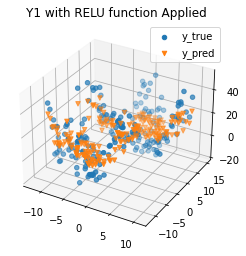

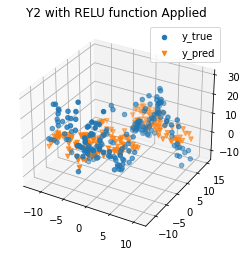

In [92]:
# Replotting the sample with y_true and y_pred
plot_3d(2, 'Y1 with RELU function Applied', X, y_true[:,0], y_pred[:,0])
plot_3d(2, 'Y2 with RELU function Applied', X, y_true[:,1], y_pred[:,1])

# Training Without RELU Activation

In [93]:
nn = Model(num_inputs=inputs, num_hidden=[4, 3], num_outputs=outputs, activation=None)
nn.fit(X, y_true, epochs)
y_pred = nn.forward(X)

err = mean_squared_error(y_true, y_pred)
print('Final MSE: {}'.format(err))

Neural Net Architecture:
=== Layer 0 ===
Layer: (3,4) Activation Function: None
Inputs:
[0. 0.]
Weights:
[[0.91274457 0.69451134 0.44038621 0.01247294]
 [0.82715308 0.18508327 0.02261633 0.99966353]
 [0.27565151 0.49055119 0.46060743 0.93259181]]
Bias:[0.29784141]
=== Layer 1 ===
Layer: (4,3) Activation Function: None
Inputs:
[0. 0.]
Weights:
[[0.83102338 0.64042662 0.32156356]
 [0.75726671 0.52838364 0.53878392]
 [0.73590108 0.1876137  0.43927061]
 [0.98074877 0.06365098 0.11630658]]
Bias:[0.25696918]
=== Layer 2 ===
Layer: (3,2) Activation Function: None
Inputs:
[0. 0.]
Weights:
[[0.9811893  0.9320789 ]
 [0.60974958 0.72321386]
 [0.15825636 0.91360544]]
Bias:[0.50111927]

Error:  232.9753233538026
Error:  178.6254769864766
Error:  168.64936084782337
Error:  171.72243072260335
Error:  208.7715047707015
Error:  159.63513508631158
Error:  162.46567863255274
Error:  180.1549428788271
Error:  157.61861706949162
Error:  164.54847734218322
Error:  162.1696000654846
Error:  177.9609382150942

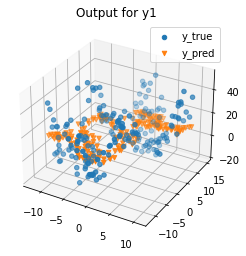

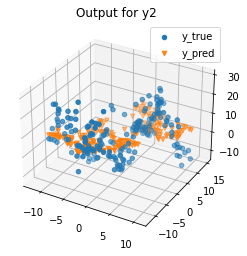

In [94]:
plot_3d(2, 'Output for y1', X, y_true[:,0], y_pred[:,0])
plot_3d(2, 'Output for y2', X, y_true[:,1], y_pred[:,1])